# Ch. 2 Linear Systems

## Section 2.1 - Direct Solution Methods for $A x=b$

We start our look at linear systems with the original solution method: __Gaussian elimination__. This basic matrix operation provides some excellent opportunities for organizing operations using `for()` loops, so let's take advantage of those opportunities to develop our execution control skills.

The basic idea is to create the augmented matrix $[A | b ]$ (by attaching the right-hand side as an extra column) and then systematically perform elementary row operations until the matrix becomes the identity. At the end of that process, the augmented column contains the solution $x$.

Let's start by coding up simpler things and then working our way up to a full solver. Let's start by importing `numpy` (to get access to `array` capabilities) and creating a sample matrix (2D array) and vector (array with a single row or column).

The example in the book involves the matrix $a=[[1,1,1],[1,2,4],[1,3,9]]$. There are many ways to create a corresponding array in python. The "manual" approach (where you enter the desired values from the keyboard is straightforward, but perhaps not terribly instructive. Here we construct the array and print the array followed by its transpose.

In [ ]:
import numpy as np #import numpy for access to array capabilities
a = np.array([[1,1,1],[1,2,4],[1,3,9]])
print('a=\n',a, "\ntranspose of a=\n", a.transpose())
print("a=")
a

The transposed version suggests an alternative algorithmic approach (so we can generalize to make arrays of different sizes). Each row in the transpose contains powers of a sequence of integers starting with 1. The code below sets the matrix size and creates a corresponding array of zeros. The values of the individual entries are then reset in the nested `for()` loops. The outer loop indexes the rows using the variable `i`. The inner loop indexes the columens using the variable `j`. And the desired values are assigned by the line `a[i,j]=(j+1)**i`.

In [ ]:
n = 3 #set the size of the square matrix
a = np.zeros([n,n]) # create a 3x3 array initialized with zeros
# reassign the entries according to the formula 1+i+j**2 where i and j are the row and column indices
for i in range(n):
    for j in range(n):
        a[i,j] = (j+1)**i   
a

That is almost the desired matrix; we just need to transpose it.

In [ ]:
a = np.transpose(a) #compare with a=a.transpose() also works
print(a)

Let's put the code above into a function to construct a similar matrix of a specified size:

In [ ]:
def make_a(n):
    """
    construct n x n matrix with columns containing powers of natural numbers
    """
    a = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            a[i,j] = (j+1)**i
    return a.transpose()

a = make_a(3)
print('a=\n',a)

Now construct the array corresponding to the vector $b=[1,-1,1]$.

In [ ]:
b = np.array([1,-1,1])
print('b=',b)

Again, an algorthmic version would be handy for contructing larger sample problems:

In [ ]:
def make_b(n):
    a = np.zeros(n)
    for i in range(n):
        a[i]=(-1)**i
    return a

print('b=',make_b(3))

__Aside__: Note that `b` looks like a row vector. If you want it to look more like a column vector (actually a 2D array with 1 column), there are ways of doing that. Here are a couple:

In [ ]:
print('transpose version:\n', np.transpose([b]))
print('newaxis version:\n',b[:, np.newaxis])

Now we are ready to start towards a solver.

The initial step involves creating the augmented matrix. Here are a couple possible python implementations. (Please consult the documentation for details.)

In [ ]:
auga= np.c_[a,b]
print('augmented matrix:\n',auga)

In [ ]:
auga = np.column_stack([a,b])
print('augmented matrix:\n',auga)

Let's build and test an `augment` function to form the augmented array given $a$ and $b$:

In [ ]:
def augment(A,b):
    return np.c_[A,b]

auga = augment(a,b)
print('The augmented matrix is:\n', auga)

Basic solver algorithms employ __elementary row operations__:

0) Swap 2 rows.

1) Multiply a row by a non-zero constant.

2) Add a multiple of one row to another.

The key useful fact is this:

__Elementary row operations leave the solution of a linear system unchanged.__

The useful approach is to apply elementary row operations to systematically transform the matrix to a simpler form until we can readily solve the system. Let's start by writing functions to implement elementary row operations 1) and 2):

In [ ]:
def row_op(A,c,i1,i2):
    """
    perform elementary row operations
    if i1==i2, multiply row by constant
    if i1!=i1, add c*(row i1) to row i2
    
    Args:
        A: 2D numpy array representing a matrix
        c: multiplicative constant
        i1,i2: row indices
    """
    m,n = A.shape
    if  i1<0 or i2<0 or i1>=m or i2>=m:
        print("WARNING: Invalid index specifications. Each index value must satisfy 0<=i<#rows.")
    if i1==i2: #repeated index -> multiply row by constant
        for j in range(n):
            A[i1,j] *= c
    else: # add c*row i1 to row i2
        for j in range(n):
            A[i2,j] += c * A[i1,j]        

The usual simplification scheme involves basic elimination to achieve __triangularization__: choose a diagonal element as a "pivot" and perform row operations to zero out each coefficient beneath it in its column. (If the preceding entries in those rows have already been set to zero, they will remain zero during the elementary row opserations, so we can proceed systematically to produce an upper triangular system.) Write a `cancel_below_pivot()` function to zero out the elements below the pivot:

In [ ]:
def cancel_below_diagonal(A, i_pivot):
    """
    insert docstring here 
    """
    m,n = A.shape
    if  i_pivot<0 or i_pivot>=m:
        print("WARNING: Invalid index specification. Index value must satisfy 0<=i<#rows.")
    if abs(A[i_pivot,i_pivot]) < 1e-8:
        print("WARNING: Division by near-zero pivot value.")
    else:
        row_op(A,1./A[i_pivot,i_pivot], i_pivot, i_pivot) #divide by pivot value so pivot position becomes 1
        for i in range(i_pivot+1,m):
            row_op(A,-A[i,i_pivot],i_pivot,i)       

In [ ]:
#test the function by zeroing the first column below the diagonal
auga = augment(a,b)
cancel_below_diagonal(auga,0)
auga

In [ ]:
#continue by zeroing the second column below the diagonal
cancel_below_diagonal(auga,1)
auga

This successfully makes the matrix upper triangular as desired. Define the function `upper_tri()` to triangularize in a single call:

In [ ]:
def upper_tri(A):
    m,n = A.shape
    for i in range(m):
        cancel_below_diagonal(A,i)

In [ ]:
auga = augment(a,b)
upper_tri(auga)
auga

Now that the matrix is triangular, we can immediately obtain the value of the last entry `x[-1]` as the last entry in the last column of the augmented array; i.e. $x_2 = 2$. This value can be plugged into the second equation to determine $x_1$, then $x_3$ and $x_2$ can be plugged into the first equation to obtain $x_1$ in a process called __back substitution__.

Implement a `back_sub()` function to execute the back substitution process:

In [ ]:
def back_sub(augU):
    m,n = augU.shape
    x = np.zeros(m)
    for i in range(m):
        x[m-i-1]= augU[m-i-1,-1]
        for j in range(m-i,m):
            x[m-i-1] -= augU[m-i-1,j]*x[j]
    return x  

In [ ]:
auga = augment(a,b)
upper_tri(auga)
print(auga)
soln = back_sub(auga)
soln

In [ ]:
# check that Ax agrees with b to within a thereshold
# print the entries in Ax-b
print("Ax-b = ", a.dot(soln)-b)
# use numpy's `allclose` function to check for numerical agreement
# to within a specified absolute and/or relative tolerance
print("Solution checks? : ", np.allclose(np.dot(a,soln),b, atol = 1e-10))

The solution method above basically works (at least in the cases we have seen so far), but the whole process needs to run again to solve with a different right-hand side `b`. Instead of repeating the computation, it is more convenient to rephrase the problem in terms of matrix factorization. The particular factorization of interest here is called the __LU Factorization__ because it involves rewriting $A$ as the product of a lower-triangular matrix $L$ and the upper-triangular $U$ that was computed above by row reduction.

Once the factorization is computed, the solution for any right-hand side can be found by solving the 2 triangular systems $L y = b$ and then $U x = y$.

Write function to compute the $LU$ factorization and to solve given $L,U,b$. 

In [ ]:
def LU_factor(A):
    m,n = A.shape
    if m != n:
        print("WARNING: Non-square input matrix")
        return
    mult = 0
    U = np.copy(A) #make a copy of the array
    #Note that U=A just makes another name for A, not a new copy of the array
    L = np.eye(n) #numpy's name for the identity matrix is "eye"
    for i in range(n): # for each row i
        for j in range(i+1,n): # for each row below row i
            mult = U[j,i]/U[i,i]
            L[j,i] = mult
            # print(i,j,U[j,i],U[i,i],mult)
            for k in range(i,n): # for each entry beyond the i^th diagonal entry
                U[j,k] = U[j,k] - mult*U[i,k] # for entries to the right, subtasct multiple of temr in row i         
            # print(L,U)
    return L,U

In [ ]:
make_a(3)

In [ ]:
L,U = LU_factor(make_a(3))
print("L= \n", L,"\nU=\n",U)

In [ ]:
# check that the factorization reproduces the input matrix
np.dot(L,U)

In [ ]:
def upper_tri_solve(U,b):
    """
    insert docstring here
    """
    m,n = U.shape #matrix has m rows and n columns
    x=np.zeros(m) #create an array to store the solution (init to zeros)
    for i in range(m):
        row = m-i-1
        accum=0 #variable to store sum of coeffs times known entries in solution
        for j in range(i):
            accum+=U[row,j]*x[j]
        x[row]=(b[row]-accum)/U[i,i] #solve for i^th entry in solution
    return x

In [ ]:
def lower_tri_solve(L,b):
    """
    insert docstring here
    """
    m,n = L.shape #matrix has m rows and n columns
    # should really check for compatible size
    y=np.zeros(m) #create an array to store the solution (init to zeros)
    for i in range(m):
        row = i
        accum=0
        for j in range(i):           
            accum+=L[row,j]*y[j]
        y[row]=(b[row]-accum)/L[i,i] #solve for i^th entry in solution
    return y

In [ ]:
# check lower_tri_solve
b = make_b(3)
y = lower_tri_solve(L,b)
print("y=",y, "residual = ", np.dot(L,y)-b)

In [ ]:
def upper_tri_solve(U,y):
    m,n = L.shape
    # Check for compatible size
    # print('Matrix has',m,'rows and',n,'columns.')
    x=np.zeros(m)
    for i in range(m):
        row = m-i-1
        accum=0
        for j in range(row+1,m):           
            accum+=U[row,j]*x[j]
            # print('row=',row,'j=', j,'accum=',accum)
        x[row]=(y[row]-accum)/U[row,row]
    return x

In [ ]:
# check upper_tri_solve
x = upper_tri_solve(U,y)
A = make_a(3)
print("x=",x, "; y=", y, "; residual = ", np.dot(A,x)-b)

In [ ]:
def LU_solve(L,U,b):
    y = lower_tri_solve(L,b)
    x = upper_tri_solve(U,y)
    return x, y

In [ ]:
N = 20
A = make_a(N)
b = make_b(N)
L,U = LU_factor(A)
x,y = LU_solve(L,U,b)
print("x=",x, "\ny=", y, "\nresidual = ", np.linalg.norm(np.dot(A,x)-b))

# ASIDE: Logistics ME535 W2020
## Start here on Th. 1/16/20

__Exam formats:__

Final will be an in class, pen(cil) and paper exam at the official date/time

Mon, Mar 16	10:30 – 12:20PM LOW 216

Midterm exam will include a similar section (so you will be less likely to be surprised by the final), but may also include a take-home computing section.

Date will be finalized soon...

# Now back to course content:

So far we have been focusing on elimination methods for solving linear systems. <br>Now let's talk about other approaches and considerations:

### Cramer's rule and Laplace expansion

You can, in fact, immediately write down the solution for any variable in the linear system $A x = b$: $$ x_i = \frac{Det(A_i)}{Det(A)}$$ where $A_i$ is $a$ with the $i^{th}$ column replaced by $b$; and you can evaluate the determinants recursively by Laplace expansion: 
$$Det(A) = \sum_{i=0}^{n-1} (-1)^{i+j} Det(A_{i,j})$$ where $A_{i,j}$ is $A$ with row $i$ and column $j$ removed.

Why not just compute the solution this way?

Where is the big computing cost?

Is there a better way to compute determinants?

Why not use Cramer's rule with a better computation of determinants?

Bottom line: Cramer's rule is handy for very small problems or deriving theoretical results, BUT...

<br><br><br><br><br><br>

__Using Cramer's rule to COMPUTE the solution of a linear system is perhaps the most efficient way to convince someone that you do not know much of anything about numerical methods.__

## Section 2.2 - Iterative Solution Methods for $Ax=b$

There is an entire class of iterative linear solvers. The basic idea is to implement a 3-step iterative scheme:

1) Make an initial estimate of the solution $x^{(0)}$.

2) Given a guess $x^{(k)}$, compute an improved estimate $x^{(k+1)}$.

3) Repeat until a stopping criterion is reached (e.g. the change between successive estimates is sufficiently small, the residual error is sufficiently small, the number of iterations reaches a maximum limit.

One of the earliest and simplest iterative solvers is __Jacobi iteration__ where the update step in step 2 is obtained by solving the $i^{th}$ equation for $x_i$. The previous estimate is plugged into the resulting expressions to produce the updated estimate.

In matrix notation, the Jacobi iteration update is:

$x^{(k+1)} = D^{-1} ((D-A)x^k + b)\qquad$ or $\qquad x^{(k+1)} = x^k + D^{-1} (b - A x^k)$

Eq. (2.2.4) poses the following linear algebra problem:

In [259]:
A1 = np.array([[4,-1,1],[4,-8,1],[-2,1,5]])
b1 = np.array([7,-21,5])
A1,b1

(array([[ 4, -1,  1],
        [ 4, -8,  1],
        [-2,  1,  5]]), array([  7, -21,   5]))

Consider solving this system by Jacobi iteration. Let's code up the recursion manually:

In [260]:
#based on Eqs.(2.2.1)
def update_1(x,y,z):
    x_new = (7+y-z)/4.
    y_new = (21+4*x+z)/8.
    z_new = (15+2*x-y)/5.
    return x_new,y_new,z_new

In [261]:
update_1(1.,2.,2.)

(1.75, 3.375, 3.0)

In [262]:
# Reproduce the results in Table 2.1
iters = 20
data = np.zeros([iters,4])
x,y,z =  1., 2., 2.
for k in range(iters):
    data[k,0] = k
    data[k,1] = x
    data[k,2] = y
    data[k,3] = z
    x,y,z = update_1(x,y,z)
print(data)

[[ 0.          1.          2.          2.        ]
 [ 1.          1.75        3.375       3.        ]
 [ 2.          1.84375     3.875       3.025     ]
 [ 3.          1.9625      3.925       2.9625    ]
 [ 4.          1.990625    3.9765625   3.        ]
 [ 5.          1.99414062  3.9953125   3.0009375 ]
 [ 6.          1.99859375  3.9971875   2.99859375]
 [ 7.          1.99964844  3.99912109  3.        ]
 [ 8.          1.99978027  3.99982422  3.00003516]
 [ 9.          1.99994727  3.99989453  2.99994727]
 [10.          1.99998682  3.99996704  3.        ]
 [11.          1.99999176  3.99999341  3.00000132]
 [12.          1.99999802  3.99999604  2.99999802]
 [13.          1.99999951  3.99999876  3.        ]
 [14.          1.99999969  3.99999975  3.00000005]
 [15.          1.99999993  3.99999985  2.99999993]
 [16.          1.99999998  3.99999995  3.        ]
 [17.          1.99999999  3.99999999  3.        ]
 [18.          2.          3.99999999  3.        ]
 [19.          2.          4.  

Here, after 20 iterations, we have converged to the solution $[2,4,3]$ to within our numerical precision.

It would be great if things always worked out so nicely, but compare with `update_2` which is the exact same problem with the first and last equation swapped. Note that this change involves performing an elementary row operation, so the exact answer is unchanged.

In [263]:
#based on Eqs.(2.2.4) with first and last equations swapped
def update_2(x,y,z):
    x_new = (y+5*z-15)/2.
    y_new = (21+4*x+z)/8.
    z_new = y-4*x+7
    return x_new,y_new,z_new

In [264]:
iters = 20
data = np.zeros([iters,4])
x,y,z =  1., 2., 2.
for k in range(iters):
    data[k,0] = k
    data[k,1] = x
    data[k,2] = y
    data[k,3] = z
    x,y,z = update_2(x,y,z)
print(data)

[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  2.00000000e+00]
 [ 1.00000000e+00 -1.50000000e+00  3.37500000e+00  5.00000000e+00]
 [ 2.00000000e+00  6.68750000e+00  2.50000000e+00  1.63750000e+01]
 [ 3.00000000e+00  3.46875000e+01  8.01562500e+00 -1.72500000e+01]
 [ 4.00000000e+00 -4.66171875e+01  1.78125000e+01 -1.23734375e+02]
 [ 5.00000000e+00 -3.07929688e+02 -3.61503906e+01  2.11281250e+02]
 [ 6.00000000e+00  5.02627930e+02 -1.24929688e+02  1.20256836e+03]
 [ 7.00000000e+00  2.93645605e+03  4.04260010e+02 -2.12844141e+03]
 [ 8.00000000e+00 -5.12647351e+03  1.20479785e+03 -1.13345642e+04]
 [ 9.00000000e+00 -2.77415116e+04 -3.97743228e+03  2.17176919e+04]
 [ 1.00000000e+01  5.22980136e+04 -1.11534193e+04  1.06995614e+05]
 [ 1.10000000e+01  2.61904826e+05  3.95260836e+04 -2.20338474e+05]
 [ 1.20000000e+01 -5.31090642e+05  1.03412729e+05 -1.00808622e+06]
 [ 1.30000000e+01 -2.46851668e+06 -3.91553474e+05  2.22778230e+06]
 [ 1.40000000e+01  5.37367151e+06 -9.55782929e+05  9.48252026e

Note that the values now grow instead of approaching the desired solution. The distinguishing property is __diagonal dominance__. When the magnitude of each diagonal term is larger than the sum of the magnitudes of the other coefficients in the row (which was the case for `update_1`), then convergence is guaranteed.

To deal with problems outside of this narrow category, a variety of embellished algorithms have been concocted. The next-simplest version is __Gauss-Seidel iteration__. The only change from Jacobi iteration is that once an updated value is computed, it gets used in the updates of the remaining variables. (See Eq. (2.2.9) for details.)


In [265]:
#Gauss-Seidel version of update_1
def update_1gs(x,y,z):
    x_new = x + (1/4.)*(7-(4*x-y+z))
    y_new = y + (-1/8.)*(-21-(4*x_new-8*y+z))
    z_new = z + (1/5.)*(15-(-2*x_new+y_new+5*z))
    return x_new,y_new,z_new

In [266]:
iters = 20
data = np.zeros([iters,4])
x,y,z =  1., 2., 2.
for k in range(iters):
    data[k,0] = k
    data[k,1] = x
    data[k,2] = y
    data[k,3] = z
    x,y,z = update_1gs(x,y,z)
print(data)

[[ 0.          1.          2.          2.        ]
 [ 1.          1.75        3.75        2.95      ]
 [ 2.          1.95        3.96875     2.98625   ]
 [ 3.          1.995625    3.99609375  2.99903125]
 [ 4.          1.99926563  3.99951172  2.99980391]
 [ 5.          1.99992695  3.99993896  2.99998299]
 [ 6.          1.99998899  3.99999237  2.99999712]
 [ 7.          1.99999881  3.99999905  2.99999972]
 [ 8.          1.99999983  3.99999988  2.99999996]
 [ 9.          1.99999998  3.99999999  3.        ]
 [10.          2.          4.          3.        ]
 [11.          2.          4.          3.        ]
 [12.          2.          4.          3.        ]
 [13.          2.          4.          3.        ]
 [14.          2.          4.          3.        ]
 [15.          2.          4.          3.        ]
 [16.          2.          4.          3.        ]
 [17.          2.          4.          3.        ]
 [18.          2.          4.          3.        ]
 [19.          2.          4.  

Note that the convergence is improved compared to the original Jacobi iteration for a diagonally dominant system.

Can Gauss-Seidel prevent divergence of the non-diagonally dominant case?

In [267]:
#based on Eqs.(2.2.4) with first and last equations swapped
def update_2gs(x,y,z):
    x_new = x + (1/5.)*(15-(-2*x+y+5*z))
    y_new = y + (-1/8.)*(-21-(4*x_new-8*y+z))
    z_new = z + (1/4.)*(7-(4*x_new-y_new+z))
    return x_new,y_new,z_new

In [268]:
# Compare with the results from update_2 where the first and last equations are swapped.
iters = 20
data = np.zeros([iters,4])
x,y,z =  1., 2., 2.
for k in range(iters):
    data[k,0] = k
    data[k,1] = x
    data[k,2] = y
    data[k,3] = z
    x,y,z = update_2gs(x,y,z)
print(data)

[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  2.00000000e+00]
 [ 1.00000000e+00  2.00000000e+00  3.87500000e+00  2.21875000e+00]
 [ 2.00000000e+00  2.80625000e+00  4.30546875e+00  1.68417969e+00]
 [ 3.00000000e+00  4.38347656e+00  5.02726074e+00 -1.13526611e-01]
 [ 4.00000000e+00  8.24494165e+00  6.73328000e+00 -4.89676661e+00]
 [ 5.00000000e+00  1.80930289e+01  1.10594186e+01 -1.72507492e+01]
 [ 6.00000000e+00  4.33691060e+01  2.21532093e+01 -4.90188656e+01]
 [ 7.00000000e+00  1.08304972e+02  5.06501278e+01 -1.30656589e+02]
 [ 8.00000000e+00  2.75153525e+02  1.23869689e+02 -3.40428544e+02]
 [ 9.00000000e+00  7.03869541e+02  3.12006202e+02 -8.79439399e+02]
 [ 1.00000000e+01  1.80545552e+03  7.95422833e+02 -2.26442936e+03]
 [ 1.10000000e+01  4.63598251e+03  2.03756259e+03 -5.82316388e+03]
 [ 1.20000000e+01  1.19090269e+04  5.22924296e+03 -1.49673391e+04]
 [ 1.30000000e+01  3.05971281e+04  1.34302717e+04 -3.84633145e+04]
 [ 1.40000000e+01  7.86162395e+04  3.45028304e+04 -9.88362677e

Apparently not (at least in this case)... so check for diagonal dominance and permute rows if it can be obtained.

## Section 2.3 - Gradient (Steepest) Descent for $Ax=b$

Another approcah to solving linear systems (that actually underlies some of the more sophisticated solvers) involves constructing an associated scalar function that has a critical point associated with the solution of the linear system.

The criterion for the critical point is that the gradient of the function vanishes (equals zero). If the vanishing of the gradient corresponds to a linear system, then the desired function will be quadratic (degree 2). The quadratic form is typically written as follows:

$f(x) = \frac{1}{2} x^T A x - b^T x + c$

and the gradient takes the form:

$\nabla f(x) = \frac{1}{2} A^T x + \frac{1}{2} A x - b$

If the matrix $A$ is symmetric, then $A^T = A$ and the condition at the critical point is:

$\nabla f(x) = A x - b = 0$ 

so the critical point of the quadratic coincides with the solution of the linear algebra problem we have been studying. If $A$ is also ___positive definite___, i.e $x^T A x > 0 \; \forall x \in ℝ^n ∖0$, then the critical point is a minimum, and the solution can be sought by systematically moving "downhill" toward the minimum point. This concept is called __gradient (or steepest) descent__.

(If $A$ is not symmetric, then gradient descent seeks the solution of $\frac{1}{2} (A^T + A) x = b$. For problems where $A$ is non-square, it can be helpful to multiply by $A^T$ and consider the __normal equations__ $A^T A x = A^T b$. The matrix $A^T A$ is symmetric and positive definite, so descent methods can be applied and the __least squares solution__ (that minimixes the least squared error $|| A x - b ||^2$) can be obtained.

Example: Compute the best-fit line to the following data set:
`t = [2,3,5,7,9], y=[4,5,7,10,15]`

The line is defined by an equation of the form <br>`y = slope*t+intercept`<br>so we have equations of the form <br>`t[i]*slope + intercept*1 = y[i]`<br> in the 2 unknowns `[slope, intercept]`.

We can write this as a linear system $ A x = b$ where:

1) the first column of $A$ is $t$

2) the second column of $A$ is all 1s

3) the unknown vector to solve for is:  `x = [slope, intercept]`

4) the right-hand side is $y$

In [269]:
t = np.array([2,3,5,7,9])
y = np.array([4,5,7,10,15])
A = np.column_stack([t,np.ones([5])])
A,y

(array([[2., 1.],
        [3., 1.],
        [5., 1.],
        [7., 1.],
        [9., 1.]]), array([ 4,  5,  7, 10, 15]))

Instead of this overconstrained non-square system, multiply by $A^T$ to get square __normal__ system:

In [270]:
A_t = np.transpose(A)
normal_A = np.dot(A_t,A)
b = np.dot(A_t,y)
normal_A, b

(array([[168.,  26.],
        [ 26.,   5.]]), array([263.,  41.]))

In [271]:
soln = np.linalg.solve(normal_A, b)
slope, intercept = soln[0], soln[1]
print("Best fit line: y = %6.2f * t + %6.2f" % (slope, intercept))

Best fit line: y =   1.52 * t +   0.30


So we obtained the best fit line using a python library function as a solver (using elimination), but let's consider alternatives.

This construction occurs frequently and ensures that the normal matrix is symmetric. Thus we should also be able to find the solution by minimizing the corresponding quadratic form. To get to notation in the book, let's rename things as follows: $A^T A \rightarrow A$ and `[slope, intercept]` $\rightarrow x$. (Sorry about that...)

The quadratic of interest is $ f(x) = \frac{1}{2} x^T A x - b^T x$

Below is sample python code for functions to compute the quadratic function and its gradient. (The "manual" function definition of the function, 'fxy', is a convenience to support plotting below.)

In [272]:
def f(x,A,b):
    y = np.dot(A,x)
    return 0.5*np.dot(x,y) - np.dot(b,x)

def fxy(x,y):
    return 0.5*(168*x**2+52*x*y+5*y**2)-(263*x+41*y)

def grad_f(x):
    g0 = 168*x[0] + 26 * x[1] - 263
    g1 = 26*x[0] + 5*x[1] - 41
    return np.array([g0,g1])

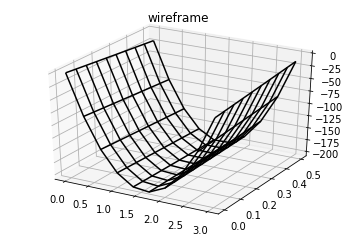

In [247]:
%matplotlib inline
x = np.linspace(0, 3, 10)
y = np.linspace(0., 0.5, 10)

X, Y = np.meshgrid(x, y)
Z = fxy(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('wireframe');

Since the quadratic function is constructed to that it's gradient is $Ax-b$, the quadratic function has a stationary point corresponding to the solution of the linear system.

For a matrix that is positive definite matrix (which is true for $A^T A$), the stationary point is a minimum.

__Gradient (Steepest) Descent Method__

1) Make an initial guess at the solution, `x[0]`

2) For a given estimate `x[i]`

3) Compute the gradient `grad_f(x[i])` (to determine steepest direction)

4) Move downhill (toward the minimum) top obtain improved solution, <br>
e.g. `x[i+1] = x[i] - c *grad_f(x[i])` note that there are other (and better) ways to update the estimate to move efficiently toward the desired minimum.

5) If `np.norm(x[i+1]-x[i]) > tol` repeat from step 2; else `return x[i+1]`

In [273]:
x0 = np.array([0,0])
A = normal_A
A, b, f(x0,A,b), grad_f(x0)

(array([[168.,  26.],
        [ 26.,   5.]]), array([263.,  41.]), 0.0, array([-263,  -41]))

In [274]:
def descent_update_const(x, c):
    return x - c*grad_f(x)

In [275]:
c = 0.01
n = 15
x = x0
for i in range(n):
    x = descent_update_const(x, c)
    print(x)

[2.63 0.41]
[0.735  0.1157]
[2.100118 0.328815]
[1.11642786 0.17634357]
[1.82497973 0.28725515]
[1.31432745 0.20839766]
[1.68207394 0.26625264]
[1.41696403 0.22560078]
[1.60780825 0.2559101 ]
[1.47015376 0.23508445]
[1.56917349 0.25109025]
[1.49767857 0.24055063]
[1.54903541 0.24912667]
[1.51188299 0.24392113]
[1.53850008 0.2486355 ]


Describe performance (or lack thereof)

See Section 2.3 in Kutz for cleaner example

Implement better approach with line search:

How far should we really move along the descent direction?<br>__Line search__ along `x[i]-c*grad_f(x[i])` to find `c` that minimizes `f(x[i+1])`.

Choose more efficient search directions:<br>Once the quadratic function has been minimized along a direction, future searches should go in orthogonal (conjugate) directions $\rightarrow$ __conjugate gradient method__

If you are interested in learning more deatils about this topic please see __"An Introduction to the Conjugate Gradient Method Without the Agonizing Pain
Edition $1 \frac{1}{4}$"__ by Jonathan Richard Shewchuk.

## Section 2.4 - Eigenvalues, Eigenvectors, and Stability

We have also not spent time discussing when a linear system is actually solvable.<br>How do we determine solvability?

For square systems, a unique solution exists if the matrix is non-singular, i.e. $Det(A) \neq 0$.

So we cannot compute solutions if $A$ is singular.

Mention fredholm alternative theorem:
<br>For solveable $Ax=b$, $b$ must be orthogonal to the null space of tha adjoint $A^{*T}$.

<br>Can we effectively compute solutions when $A$ is non-singular?
<br>Sometimes...

Introduce __Condition number__ as a measure of the ratio of relative residual $$\frac{||Ax-b||}{||b||}$$ to relative error $$\frac{||x-x_{exact}||}{||x_{exact}||}$$

All of these things relate to eigenvalues and eigenvectors: How?

Consider iterative computation of eigenvalues and eigenvectors.

Ratio of eigenvalues provides bounds for condition number...